Last Change: 2020/02/06 14:50:09.

auther: tsuyo-pon

# VBGMM を使ってみよう!
やっぱり機械学習は，練習しないと覚えられません．

特に教師なし機械学習でクラスタリングなんて，自分で色々試行錯誤して算出しないとダメですね．

なので，まず機械学習のVBGMMなる奴を行います．

![sklearn_cheat_sheet](../image/sklearn_cheat_sheet.png "scikitleanが出している写真")
(https://scikit-learn.org/stable/tutorial/machine_learning_map/ より抜粋)

VBGMM は左下のエリアにいますね．

## Contents
1. データの準備
1. 分布の確認
1. k-means の実施・確認
1. VBGMM の実施・確認
1. 各データのクラスタを確認
1. 各クラスタの重みを確認
1. 各クラスタの重みを再確認 (おまけ)

## データの準備
[]({{{)
まずはデータを準備しましょう．

といってもいきなり複雑なデータを使ってしまうと，何がなんだかわかんなくなってしまいます．

そこで，Numpy で作成した単純なデータを使用しましょう．

In [1]:
# 必要なライブラリをインポート
import numpy as np
from numpy.random import rand

In [2]:
# Numpy で乱数データを作成
vec_list = []
# for base in [[10, 10]]:
for base in [[10, 10], [0, 0]]:
    for _ in range(100):
        temp = [base[0] + rand(), base[1] + rand()]
        vec_list.append(temp)
nvec = np.array(vec_list)

データを生成したので，中身を見てみましょう．
ここは軽く確認するだけですので，最初と最後の 5 個を見ます．

In [3]:
# 生成データの確認
print("最初の 5 個:\n {}".format(nvec[:5]))
print("最後の 5 個:\n {}".format(nvec[-5:]))

最初の 5 個:
 [[10.15035506 10.17939655]
 [10.8130971  10.81132425]
 [10.96846017 10.19124972]
 [10.67784734 10.10795736]
 [10.12647028 10.8618151 ]]
最後の 5 個:
 [[0.76089164 0.97108752]
 [0.13312931 0.41743604]
 [0.03279799 0.35606944]
 [0.12773034 0.75218187]
 [0.76269666 0.18835898]]


序盤がだいたい 10-11 くらいで，終盤が 0-1 くらいですね．

これでひとまず分類に必要なデータを用意できました．
[](}}})

## 分布の確認
[]({{{)
分析するデータを手に入れたから，早速機械学習を...

<br/>

<div style="text-align: center;">
<h3>ちょっと待て!!!</h3>
</div>

<br/>

データを手に入れたら解析を始める前に，**まず**分布を確認しよう (これは解析を始める前の癖にすることを強く勧めます)．

分布を確認して，明らかな外れ値があったり，あるいは自身の予想と全く異なる分布であったら，検討する必要があります
(今回は Numpy で生成したデータなので分布は分かっていますが，こういうのは常に確認するくらいの気持ちでいいです)．

In [4]:
# 必要なライブラリをインポート
import matplotlib.pyplot as plt

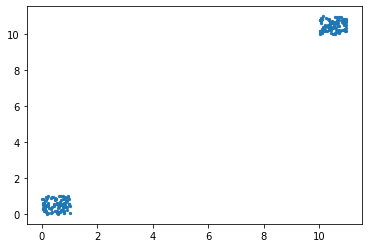

In [5]:
# データの分布を確認
x = [nvec[i][0] for i in range(len(nvec))]
y = [nvec[i][1] for i in range(len(nvec))]

plt.scatter(x, y, s=5)
plt.show()

データの準備の段階でだいたい予想が付いていたかもしれませんが，(10, 10) 付近と (0, 0) 付近に分布しています．

ひとまず，これでデータの分布が確認できました．
[](}}})

## k-means の実施・確認
[]({{{)
分布も確認したので，いよいよデータを分類していきましょう．

まずは教師なし分類手法で有名な k-means 法を行います．
k-means 法は，あらかじめクラスタ数を定める必要があります．

そのため，クラスタ数に関わる仮説や教師データが存在しない場合，クラスタ数を決定するのは大変です．
クラスタ数ごとにモデルの良さを評価し，色々なクラスタ数でモデルの良さを確認して，最も妥当なクラスタ数を探索する必要があります (それをやってくれる x-means 法なるものがあるらしですが，今回は割愛)．

今回はあらかじめ教師情報があるので，クラスタ数は "2" として学習を行います (n_clusters=2 の部分で指定しています)．

In [6]:
# 必要なライブラリをインポート
from sklearn import cluster

In [7]:
# k-means 法で学習
km = cluster.KMeans(n_clusters=2)
z_km = km.fit(nvec)

k-means 法で学習したので，結果を確認しましょう．

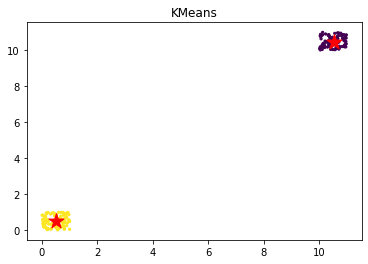

In [8]:
# 散布図を作成
plt.scatter(x, y, c=z_km.labels_, s=5)

# 重心を★マークでをプロット
plt.scatter(
    z_km.cluster_centers_[:, 0],
    z_km.cluster_centers_[:, 1],
    s=250,
    marker="*",
    c="red",
)
plt.title("KMeans")
plt.show()

分類ごとに色分けをしましたが，右上と左上で二色に別れてそれぞれの中心ぽい場所に★マークも出ていると思います．

まぁ大方予想通りというか，特に違和感もない結果になったと思います (生成データなのでそりゃそうですが)．
[](}}})

## VBGMM の実施・確認
[]({{{)
k-means 法での分類を確認しました．
今度は VBGMM で分類していきましょう．

k-means 法ではクラスタ数を指定しましたが，VBGMM はデータを自動でクラスタに分けるためクラスタ数を指定しません．

その代わりというわけではありませんが，クラスタ数の上限値を定める必要があります (n_components=n_components の部分で指定しています)．

今回は，上限値を 10 と設定して学習を行いました．

In [9]:
# 必要なライブラリをインポート
from sklearn import mixture

In [10]:
# VBGMM で学習
n_components=10
vbgmm = mixture.BayesianGaussianMixture(n_components=n_components, random_state=3)
vbgmm = vbgmm.fit(nvec)
labels = vbgmm.predict(nvec)

VBGMM で学習したので，結果を確認しましょう．

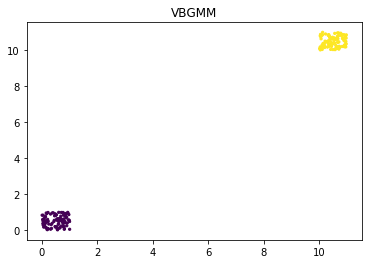

In [11]:
# 散布図を作成
plt.scatter(x, y, c=labels, s=5)
plt.title("VBGMM")
plt.show()

今回も分類ごとに色分けしました．
特にクラスタ数は指定しませんでしたが，分布は k-means 法と同様に右上と左下で綺麗に二色に分かれたと思います (分かれていてほしい)．

※ random_state=3 について．

今回は初期値を固定するためにあえて整数値を指定しましたが，本来は固定しません．
そのため，デフォルトでは random_state=None となっています．

[](}}})

## 各データのクラスタを確認
[]({{{)
VBGMM でクラスタ数を指定せずとも分類できることが確認できました．

分類できることが分かったので，次はどのデータがどのクラスタか調べましょう．
最初と最後の 5 個を確認します (データは 0 番目から 199 番目で 200 個となっています)．

In [12]:
# クラスタの確認
for i in range(len(labels)):
    if i < 5:
        print("{} 番目 | クラスタ: {}, データ: {}".format(i, labels[i], nvec[i]))
    elif i > 194:
        print("{} 番目 | クラスタ: {}, データ: {}".format(i, labels[i], nvec[i]))

0 番目 | クラスタ: 4, データ: [10.15035506 10.17939655]
1 番目 | クラスタ: 4, データ: [10.8130971  10.81132425]
2 番目 | クラスタ: 4, データ: [10.96846017 10.19124972]
3 番目 | クラスタ: 4, データ: [10.67784734 10.10795736]
4 番目 | クラスタ: 4, データ: [10.12647028 10.8618151 ]
195 番目 | クラスタ: 2, データ: [0.76089164 0.97108752]
196 番目 | クラスタ: 2, データ: [0.13312931 0.41743604]
197 番目 | クラスタ: 2, データ: [0.03279799 0.35606944]
198 番目 | クラスタ: 2, データ: [0.12773034 0.75218187]
199 番目 | クラスタ: 2, データ: [0.76269666 0.18835898]


ざっくりと，0-1のデータが一つのクラスタで，10-11のデータが一つのクラスタになっていると思います．

これで，各データがどのクラスタにいるのか分かりました．
[](}}})

## 各クラスタの重みを確認
[]({{{)
各データがどのクラスタにいるのかは分かったと思いますが，全体としてどのような傾向になっているのかは，まだつかめていません．

そこで，各クラスタにどの程度のデータが存在しているのか，確認をしましょう．

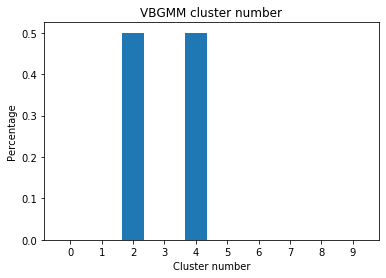

In [13]:
# VBGMM でクラスタ数を確認
x_tick = np.array(range(n_components))
cluster_weights = [np.count_nonzero(labels == i) / len(labels)  for i in range(n_components)]
plt.bar(x_tick, cluster_weights, width=0.7, tick_label=x_tick)
plt.title("VBGMM cluster number")
plt.xlabel("Cluster number")
plt.ylabel("Percentage")
plt.show()

クラスタを確認した際に出てきた二つのクラスタが，大きく飛び出ていると思います．

棒グラフを見る限りでは，二つのクラスタがそれぞれ全データの約 50% を占めているので，クラスタ数は 2 と判断できるでしょう．
[](}}})

## 各クラスタの重みを再確認 (おまけ)
[]({{{)
上の結果でクラスタ数は 2 と分かったと思います．

ただ私はその昔 (二ヶ月前)，クラスタの番号が，それぞれ対応しているクラスタ数の確率を示していると勘違いしていました．

しかし実際は，クラスタの番号に意味はなく，(大きく) 飛び出た本数がクラスタ数となります．

そのため，下の二つを確かめるために，改めて VBGMM で学習を行います．
- クラスタの番号に意味はない．
- (大きく) 飛び出た本数がクラスタ数である．

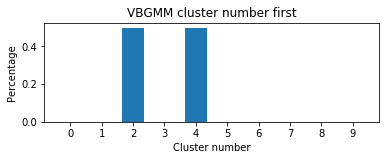

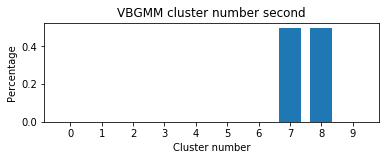

In [14]:
# VBGMM でクラスタ数を確認 (先ほどのグラフを再掲)
plt.subplot(2, 1, 1)
x_tick = np.array(range(n_components))
cluster_weights = [np.count_nonzero(labels == i) / len(labels)  for i in range(n_components)]
plt.bar(x_tick, cluster_weights, width=0.7, tick_label=x_tick)
plt.title("VBGMM cluster number first")
plt.xlabel("Cluster number")
plt.ylabel("Percentage")
plt.show()

# VBGMM で再学習
n_components=10
vbgmm = mixture.BayesianGaussianMixture(n_components=n_components, random_state=8)
vbgmm = vbgmm.fit(nvec)
labels = vbgmm.predict(nvec)

# VBGMM でクラスタ数を再確認
plt.subplot(2, 1, 2)
x_tick = np.array(range(n_components))
cluster_weights = [np.count_nonzero(labels == i) / len(labels)  for i in range(n_components)]
plt.bar(x_tick, cluster_weights, width=0.7, tick_label=x_tick)
plt.title("VBGMM cluster number second")
plt.xlabel("Cluster number")
plt.ylabel("Percentage")
plt.show()

上のグラフが，最初に VBGMM で確認したクラスタ数です．
下のグラフが，今回算出した VBGMM でのクラスタ数です．

おそらく今回も最初と同様に，二つのクラスタが，大きく飛び出ていると思います．
しかし最初とは，違うクラスタが大きく飛び出ているのではないかと思います．

分類に使用したデータはもちろん同じなので，この二つのグラフはほぼ同じ意味を持っているはずです．

二つのグラフがほぼ同じ意味を持っていると考えると，おそらくクラスタの番号に意味はなく，(大きく) 飛び出た本数がクラスタ数なのではないかと考えられるでしょう．
[](}}})

[home](../)